#### Importing Neccessary Libraries

In [82]:
import os
import random
from os import listdir
import json
from shutil import copyfile
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import PIL
import time
import datetime
import tensorflow as tf
import keras
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from tensorflow.keras.applications import InceptionV3, InceptionResNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [14]:
# Definig loader parameters
data_dir = "8-Objects-Training"
batch_size = 32
img_height = 224
img_width = 224

# IMAGE SHAPE
IMAGE_SHAPE = (img_height, img_width)


ResNet_path = 'imagenet_resnet_v2_50_classification_5'

# Load the saved model
classifier_model = tf.saved_model.load(ResNet_path)

In [15]:
# declare the classifier
classifier = tf.keras.Sequential([hub.KerasLayer(classifier_model, input_shape=IMAGE_SHAPE+(3,))])

#### Test the classifier on a single image

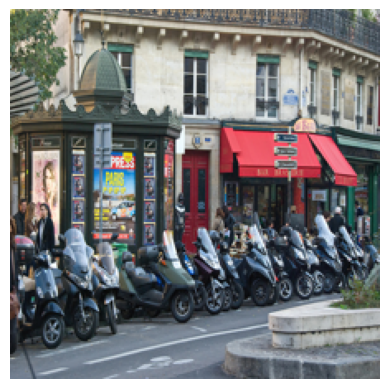

In [16]:
# testing image path
image_folder = 'model_test'

# List all files in the folder
image_files = os.listdir(image_folder)

# Choose a random image file
random_image_file = random.choice(image_files)

# Open the randomly selected image using PIL
image_path = os.path.join(image_folder, random_image_file)
img = Image.open(image_path)

# Resize the image to 224x224 pixels (or any desired size)
img = img.resize((224, 224))

# Load and display the randomly chosen image using matplotlib
plt.imshow(img)
plt.axis('off')  # Turn off axis labels
plt.show()

In [17]:
img = np.array(img)/255.0
img.shape

(224, 224, 3)

#### Adding a batch dimension (with np.newaxis) and pass the image to the model

In [20]:
result = classifier.predict(img[np.newaxis, ...])
result.shape

1/1 [==============================] - 0s 81ms/step


(1, 1001)

In [21]:
predicted_class = tf.math.argmax(result[0], axis=-1)
predicted_class

<tf.Tensor: shape=(), dtype=int64, numpy=671>

#### Decode the predictions by taking the predicted_class ID and fetching the ImageNet dataset labels to decode the predictions.

In [22]:
labels_path = tf.keras.utils.get_file('ImageNetLabels.txt','https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
imagenet_labels = np.array(open(labels_path).read().splitlines())

#### Visualise the result 

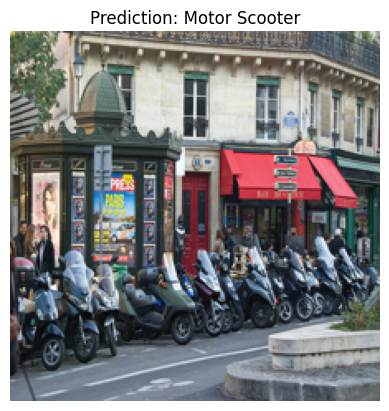

In [24]:
plt.imshow(img)
plt.axis('off')
predicted_class_name = imagenet_labels[predicted_class]
_ = plt.title("Prediction: " + predicted_class_name.title())

## Transfer learning with ResNet

Selecting a pre-trained model (ResNet) from TensorFLowHub, and retraining the top (last) layer to recognize the class from my dataset

#### First, load this data into the model using the image data off disk with tf.keras.utils.image_dataset_from_directory, which will generate a tf.data.Dataset from image file in a directory

In [25]:
# training data set 
train_ds = tf.keras.utils.image_dataset_from_directory(data_dir, 
                                                       validation_split = 0.2, 
                                                       subset = "training", 
                                                       seed = 123, 
                                                       image_size = IMAGE_SHAPE, 
                                                       batch_size = batch_size)

Found 4669 files belonging to 8 classes.
Using 3736 files for training.


In [26]:
# Validation data set
val_ds = tf.keras.utils.image_dataset_from_directory(data_dir,
                                                    validation_split = 0.2,
                                                    subset = "validation",
                                                    seed = 123,
                                                    image_size = IMAGE_SHAPE,
                                                    batch_size = batch_size)

Found 4669 files belonging to 8 classes.
Using 933 files for validation.


#### The Datasets has 8 Classes

In [27]:
# getting the class names 
class_names = train_ds.class_names
print(class_names)

['Airplanes', 'Bikes', 'Buses', 'Cars', 'Helicopters', 'Ships', 'Trains', 'Trucks']


#### Displaying 9 images from the dataset

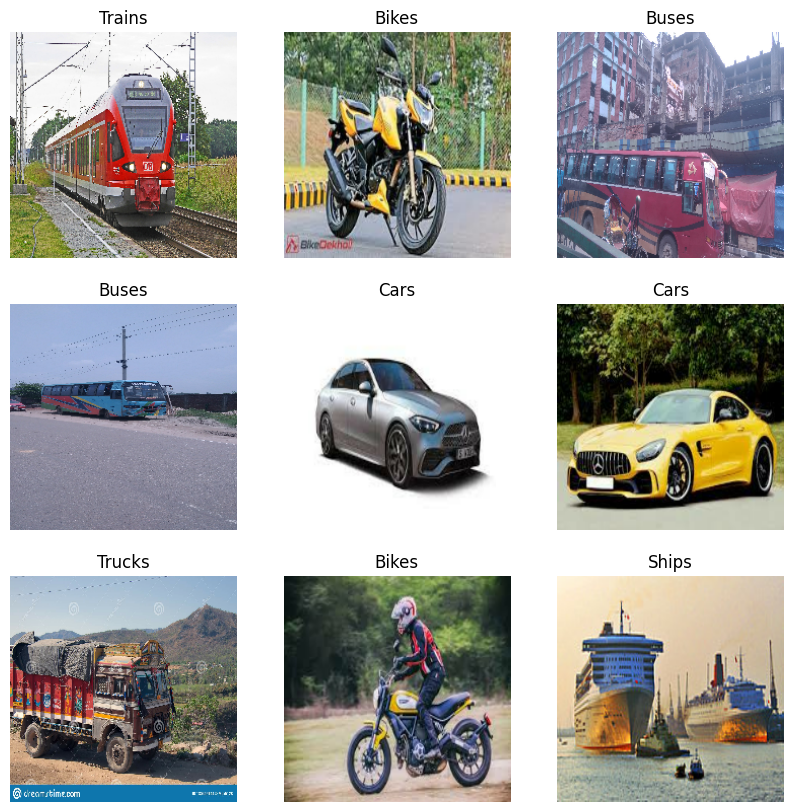

In [29]:
plt.figure(figsize=(10,10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

#### Because TensorFlow Hub's convention for image models is to expect float inputs in the [0, 1] range, use the tf.keras.layers.Rescaling preprocessing layer to achieve this.

In [32]:
normalization_layer = tf.keras.layers.Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y)) # Where x—images, y—labels.
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y)) # Where x—images, y—labels.

In [121]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [46]:
# Iterate and retrieve batches of images
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break;

(32, 224, 224, 3)
(32,)


#### Run the classifier on a batch of images

In [47]:
result_batch = classifier.predict(train_ds)

117/117 [==============================] - 135s 1s/step


In [48]:
predicted_class_names = imagenet_labels[tf.math.argmax(result_batch, axis=-1)]
predicted_class_names

array(['moped', 'recreational vehicle', 'liner', ..., 'sports car',
       'moped', 'pay-phone'], dtype='<U30')

#### Visualize the predictions

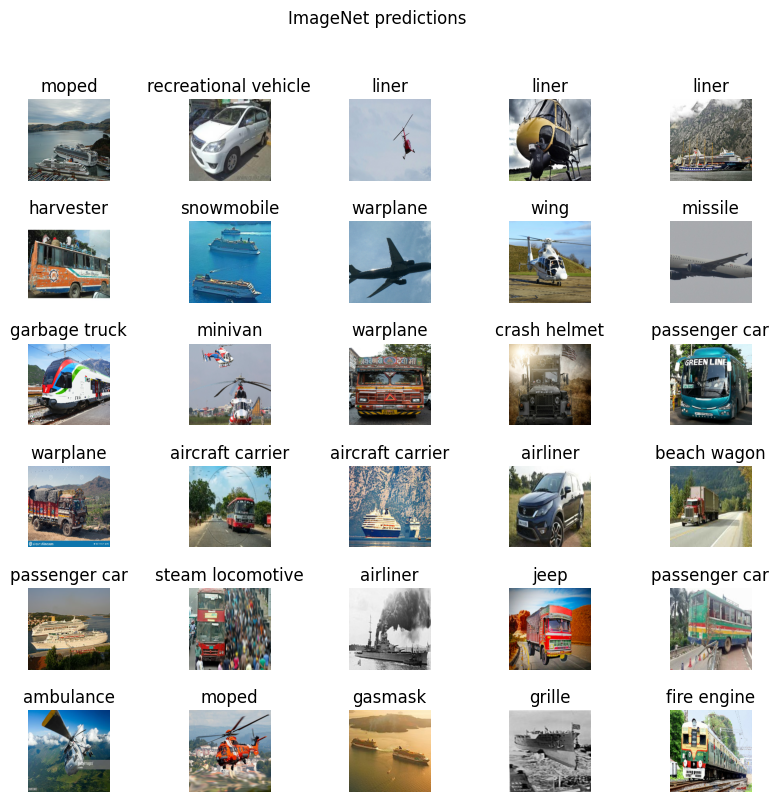

In [49]:
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch[n])
  plt.title(predicted_class_names[n])
  plt.axis('off')
_ = plt.suptitle("ImageNet predictions")


#### Above result are far from perfect, but reasonable considering that these are not the classes the model was trained for 

#####

### Using the pretrainf model from TensorFLow Hub. (ResNet) 

In [52]:
feature_extractor_model = classifier_model

#### Creating the feature extractor by wrapping the pre-trained model as a Keras layer with hub.KerasLayer. 

In [53]:
feature_extractor_layer = hub.KerasLayer(
    feature_extractor_model,
    input_shape=(224, 224, 3),
    # Using the trainable=False argument to freeze the variables, so that the training only modifies the new classifier layer:
    trainable=False) 

In [54]:
feature_batch = feature_extractor_layer(image_batch)
print(feature_batch.shape)

(32, 1001)


#### Attaching a classification head by wrapping the feature extraction in  a tf.keras.Sequential model and add a fully-connected layer for classification 

In [55]:
num_classes = len(class_names)

model = tf.keras.Sequential([
  feature_extractor_layer,
  tf.keras.layers.Dense(num_classes)
])

model.summary()


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_4 (KerasLayer)  (None, 1001)              25615849  
                                                                 
 dense (Dense)               (None, 8)                 8016      
                                                                 
Total params: 25,623,865
Trainable params: 8,016
Non-trainable params: 25,615,849
_________________________________________________________________


In [56]:
predictions = model(image_batch)

In [57]:
predictions.shape

TensorShape([32, 8])

In [58]:
#### Training the model and adding a tf.keras.callbacks.TensorBoard callback to create and store logs

In [59]:
#### Train the model
model.compile(
  optimizer=tf.keras.optimizers.Adam(),
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['acc'])

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir=log_dir,
    histogram_freq=1) # Enable histogram computation for every epoch.

#### Training for 10 epochs and to visualize the training progress in TensorBoard later, create and store logs an a TensorBoard callback.

In [60]:
NUM_EPOCHS = 10

history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=NUM_EPOCHS,
                    callbacks=tensorboard_callback)


Got `type(handle)`: <class 'tensorflow.python.saved_model.load.Loader._recreate_base_user_object.<locals>._UserObject'>
Epoch 1/10
117/117 [==============================] - 175s 1s/step - loss: 0.4558 - acc: 0.8557 - val_loss: 0.1977 - val_acc: 0.9432
Epoch 2/10
117/117 [==============================] - 177s 2s/step - loss: 0.1233 - acc: 0.9553 - val_loss: 0.1801 - val_acc: 0.9518
Epoch 3/10
117/117 [==============================] - 174s 1s/step - loss: 0.0846 - acc: 0.9738 - val_loss: 0.1751 - val_acc: 0.9550
Epoch 4/10
117/117 [==============================] - 172s 1s/step - loss: 0.0612 - acc: 0.9805 - val_loss: 0.1670 - val_acc: 0.9582
Epoch 5/10
117/117 [==============================] - 173s 1s/step - loss: 0.0464 - acc: 0.9872 - val_loss: 0.1627 - val_acc: 0.9582
Epoch 6/10
117/117 [==============================] - 170s 1s/step - loss: 0.0350 - acc: 0.9922 - val_loss: 0.1670 - val_acc: 0.9550
Epoch 7/10
117/117 [==============================] - 172s 1s/step - loss: 0.0278

In [61]:
#### Starting TensorBoard to view how the metric change with each epoch and track other scalar values

In [62]:
%load_ext tensorboard
%tensorboard --logdir logs/fit

Reusing TensorBoard on port 6006 (pid 18924), started 15:15:07 ago. (Use '!kill 18924' to kill it.)

In [ ]:
#### Checking the predictions

In [63]:
predicted_batch = model.predict(image_batch)

predicted_id = tf.math.argmax(predicted_batch, axis=-1)
predicted_id

1/1 [==============================] - 2s 2s/step


<tf.Tensor: shape=(32,), dtype=int64, numpy=
array([5, 3, 4, 4, 5, 2, 5, 0, 4, 0, 6, 4, 7, 7, 2, 7, 2, 5, 3, 7, 5, 2,
       5, 7, 2, 4, 4, 5, 5, 6, 0, 7], dtype=int64)>

In [68]:
# Convert the predicted_id tensor to a NumPy array
predicted_id = predicted_id.numpy()

In [69]:

# Now, you can index the class_names array using predicted_id
predicted_label_batch = [class_names[i] for i in predicted_id]
print(predicted_label_batch)

['Ships', 'Cars', 'Helicopters', 'Helicopters', 'Ships', 'Buses', 'Ships', 'Airplanes', 'Helicopters', 'Airplanes', 'Trains', 'Helicopters', 'Trucks', 'Trucks', 'Buses', 'Trucks', 'Buses', 'Ships', 'Cars', 'Trucks', 'Ships', 'Buses', 'Ships', 'Trucks', 'Buses', 'Helicopters', 'Helicopters', 'Ships', 'Ships', 'Trains', 'Airplanes', 'Trucks']


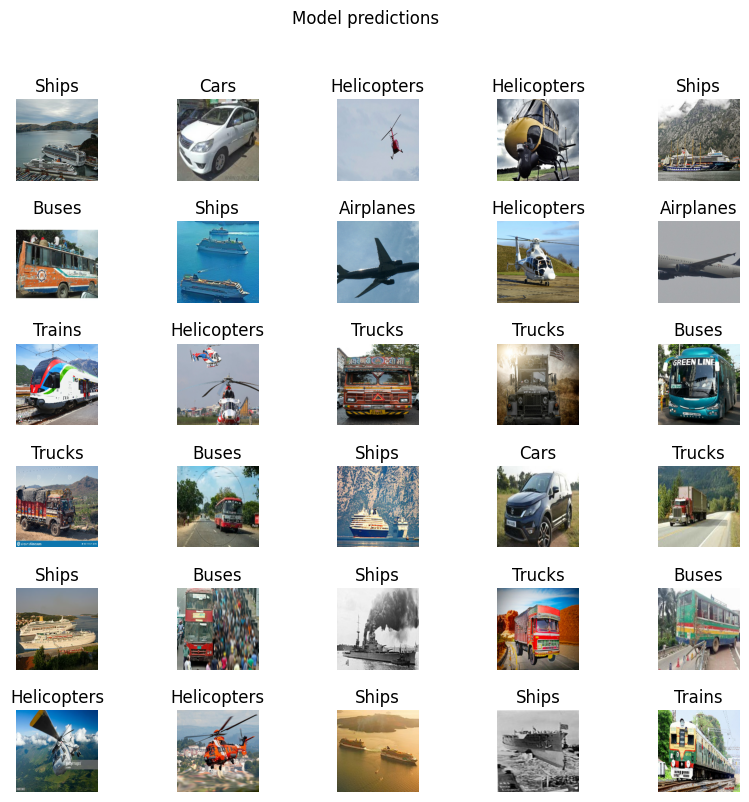

In [70]:
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)

for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch[n])
  plt.title(predicted_label_batch[n].title())
  plt.axis('off')
_ = plt.suptitle("Model predictions")

In [71]:
# Exporting and reloading the model

In [72]:
t = time.time()

In [73]:
export_path = "/tmp/saved_models/{}".format(int(t))
model.save(export_path)

export_path

INFO:tensorflow:Assets written to: /tmp/saved_models/1694346393\assets


INFO:tensorflow:Assets written to: /tmp/saved_models/1694346393\assets


'/tmp/saved_models/1694346393'

In [74]:
# comfirm the model

In [75]:
reloaded = tf.keras.models.load_model(export_path)

In [76]:
result_batch = model.predict(image_batch)
reloaded_result_batch = reloaded.predict(image_batch)

1/1 [==============================] - 2s 2s/step


In [77]:
abs(reloaded_result_batch - result_batch).max()

0.0

In [78]:
reloaded_predicted_id = tf.math.argmax(reloaded_result_batch, axis=-1)
reloaded_predicted_id = reloaded_predicted_id.numpy()

In [79]:
# Now, you can index the class_names array using predicted_id
reloaded_predicted_label_batch = [class_names[i] for i in reloaded_predicted_id]
print(reloaded_predicted_label_batch)

['Ships', 'Cars', 'Helicopters', 'Helicopters', 'Ships', 'Buses', 'Ships', 'Airplanes', 'Helicopters', 'Airplanes', 'Trains', 'Helicopters', 'Trucks', 'Trucks', 'Buses', 'Trucks', 'Buses', 'Ships', 'Cars', 'Trucks', 'Ships', 'Buses', 'Ships', 'Trucks', 'Buses', 'Helicopters', 'Helicopters', 'Ships', 'Ships', 'Trains', 'Airplanes', 'Trucks']


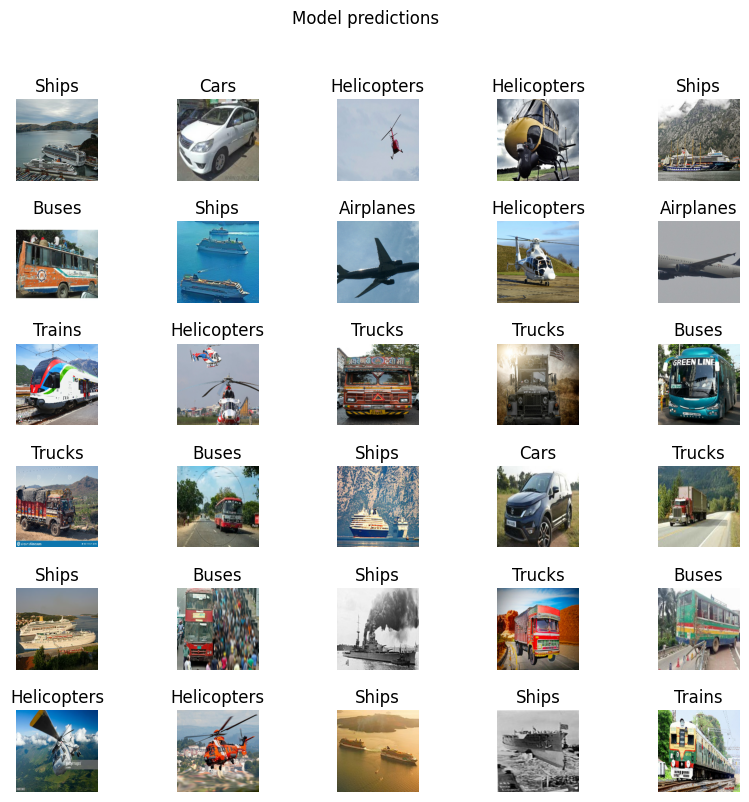

In [80]:
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch[n])
  plt.title(reloaded_predicted_label_batch[n].title())
  plt.axis('off')
_ = plt.suptitle("Model predictions")